# **Analyzing CLL-dwr+upr-GEN-dwr+upr-CLL embeddings**

In this notebook we illustrate some basic analysis one can do to start exploring a Bioteque embedding space. As example we will take the metapath 'CLL-dwr+upr-GEN-dwr+upr-CLL', which links cell line nodes to other cell lines according to their Gene expression similarity. Within these notebook there are two folders with data:

- **data**: Here we just unzipped the embedding file obtained from the resource. 
- **metadata**: Here we provide some metadata used for downstream analysis. More specifically:
    - cl2tis.csv --> We provide cell mappings to their tissue of origin Data was obtained from parsing the cell metadata table available in https://clue.io/cell-app 
    - gdsc1000_sens_callings.csv --> Cell sensitivity callings for hundreds of drugs obtained from the GDSC1000 (https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Drug_screening_data.html). There we already mapped the cell lines to the Cellosaurus ids used in our resource.

**Disclaimer**: For the sake of simplicity and efficiency, we have choosen an embedding space with a moderate number of nodes (~1000). However, some of the embeddings in our resource may cover up to 20,000 nodes, which make cause some of the algorithms or methods used here take much more time, or even be unfeasiable to compute depending on the computer capabilities.

In [1]:
import h5py
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline


# Path to the embedding data
data_path = './embedding_folder/CLL-dwr+upr-GEN-dwr+upr-CLL/ccle_rna-ccle_rna/' 

# Path to other metadata used for downstream analysis
metadata_path = './metadata/' 

source_entity = 'CLL'
target_entity = 'CLL'

## **0) Reading an embedding file**

Bioteque embeddings are saved in a Hierarchical Data Format (HDF), especially optimized to save multidimensional data. In python we have the hp5y package which allow us to read, write and modify this documents.


In [2]:
def read_embedding(path, entity):
    
    #--Reads the ids of the embeddings
    with open(path+'/%s_ids.txt'%entity) as f:
        ids = f.read().splitlines()
        
    #--Reads the embedding vectors 
    with h5py.File(path+'%s_emb.h5'%entity,'r') as f:
        emb =  f['m'][:]
        
    return ids,emb

#------------------
    
ids, emb = read_embedding(data_path, source_entity)
# ids2, emb2 = read_embedding(data_path, target_entity) # Not need in this example as source == target

**Important**: Some embeddings will have different source and target entities. Embeddings for each entity are kept in separate HD5 files, so you need to read them separately by calling twice the *read_embedding()* function, especifying the entity/metanode (mnd) of interest.

## **1) 2D projection (tSNE)**

### **1.1) Obtaining 2D embedding representation**

A good way to visually inspect an embedding space is by projecting the vectors in a 2D space. For that we first need to compress the 128d into a 2D matrix. We can use the tSNE implementation from sklearn for this task.

In [3]:
from sklearn.manifold import TSNE

n_cpus = 1 # You can accelerate the training by using more cpus

tsne = TSNE(n_jobs=n_cpus)# Usually default parameters are ok but feel free to explore!
emb2D = tsne.fit_transform(emb) 

print(emb.shape, emb2D.shape)


(1198, 128) (1198, 2)


### **1.2) Plotting 2D representation**

We can use a Scatter plot to visualize the 2D dimensional space we have just created

In [4]:
def plot_tSNE(emb2D, interactive=False, color=None, lb2col=None, dot_size=20, alpha=0.75, figsize=(5,5), dpi=100):
    
    if interactive is True:
        import plotly.express as px
        px.scatter(emb2D, x=0,y=1,  width=600, height=600, color=color, hover_name=ids).show()
    else:
        plt.figure(figsize=figsize,dpi=dpi)
        plt.scatter(emb2D[:,0], emb2D[:,1], color=color, s=dot_size, alpha=alpha, edgecolor='k', linewidth=0.1)
    plt.xticks([])
    plt.yticks([])
    
    if lb2col:
        #--Legend handlesA
        legend_handles = [Line2D([0], [0], marker='o', color='k',label='%s'%lb, 
                                 markerfacecolor=lb2col[lb], markersize=7, linewidth=0, markeredgewidth=0.5)
                           for lb in sorted(lb2col)]
        L = plt.legend(handles=legend_handles, loc=7, frameon=False, handletextpad=0.001, 
                       ncol=3, columnspacing=0.04, bbox_to_anchor=(2.7,0.5))



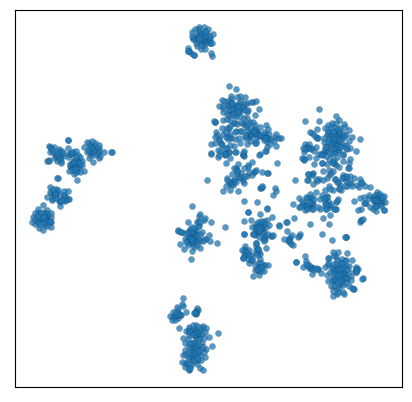

In [5]:
plot_tSNE(emb2D)

Notice how the 2D project reveals some cluster of cell lines that are far apart from the rest. While we could check the coordenates of the 2D projection to know which cell lines are there, we can also try to color the 2D projection according to some side information to see whether we have some clue.

### **1.3) Coror by property (tissue)**

Sometimes, we may want to color the nodes in the 2D projection according to some attribute. For instance, we could color each cell line according to their tissue of origin. 

In the clue.io cell app (https://clue.io/cell-app) we can obtain cell information (such their tissue lineage) from thousands of cell lines. More importantly, the cellosaurus ID is also annotated, preventing us from having to map the cell lines.


For this tutorial we have already parsed their cell table and assigned a color for each tissue. However, feel free to download their data and color the cell lines according to another property of interest! (e.g. primary disease).


In [6]:
#--Reading cell metadata preprocessed from clue.io/cell-app
cll_metadata = pd.read_csv(metadata_path+'/cl2tis.csv.gz')
cll_metadata.head()



cl_name      cl_id                              tissue    color
0   105KC  CVCL_M605                         soft_tissue  #800000
1    1184  CVCL_2263                                skin  #4363d8
2  1205LU  CVCL_5239                                lung  #3cb44b
3    1221  CVCL_2264                                skin  #4363d8
4    1301  CVCL_2265  haematopoietic_and_lymphoid_tissue  #e6194B

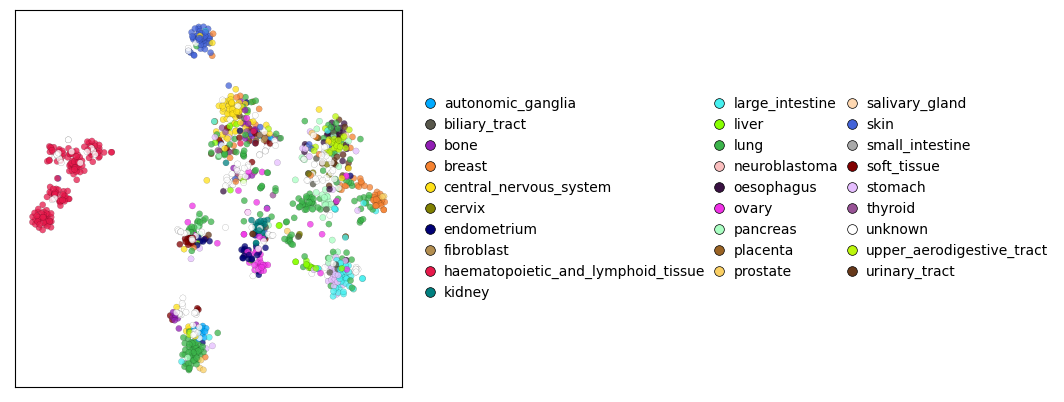

In [7]:
unknown_color = 'white' # We will use this color if the cel tissue is unknown

# Get a list of colors for each cell
cl2col = dict(cll_metadata[['cl_id','color']].values) # This maps each cell line to the color of their tissue
colors = [cl2col[cl] if cl in cl2col else unknown_color for cl in ids] # We create a vector of colors for each cell line
                                                                       # Importantly, the order must be the same than the cell lines in the embedding matrix

# We can use a dictionary mapping tissues to colors to have a legend in our plot
tis2col = dict(cll_metadata[['tissue','color']][cll_metadata['color'].isin(colors)].values)
tis2col['unknown'] = unknown_color

# Plot tsne providing the list of colors and a dictionary for the legend
plot_tSNE(emb2D, color=colors, lb2col=tis2col)

After coloring the cell lines we can now see that the cluster falling apart is mostly composed of haematopoietic and lymphoid cell lines (in red). Notice that there are also some cell lines of 'unknown' tissue (white dots) that, according to this projection, are likely to belong to this group. 

### **1.4) Interactive TSNE map**

The *plotly* python library offers some utilities to make interactive plots. Here we have prepared a function that will project an interactive tSNE which will allow you to explore the 2D space.

In [8]:
import plotly.express as px
def plot_interactive_tSNE(emb2D, custom_data=None, side_info_labels=None, side_info_labels_colors=None, width=600, height=600):
     
    if custom_data:
        hover_data = [custom_data[x] for x in sorted(custom_data)]
        hovertemplate = [x+": %{customdata["+"%i"%i+"]}" for i,x in enumerate(sorted(custom_data))] + [ "X: %{x}","Y: %{y}"]
    else:
        hover_data = None
        hovertemplate = ['X: %{x}', 'Y: %{y}']
        
    if side_info_labels != None:
        width +=200
        
    px.scatter(emb2D, x=0, y=1,  width=width, height=height, custom_data = hover_data,
           color=side_info_labels, color_discrete_map=side_info_labels_colors).update_traces(hovertemplate="<br>".join(hovertemplate)).show()
    
    

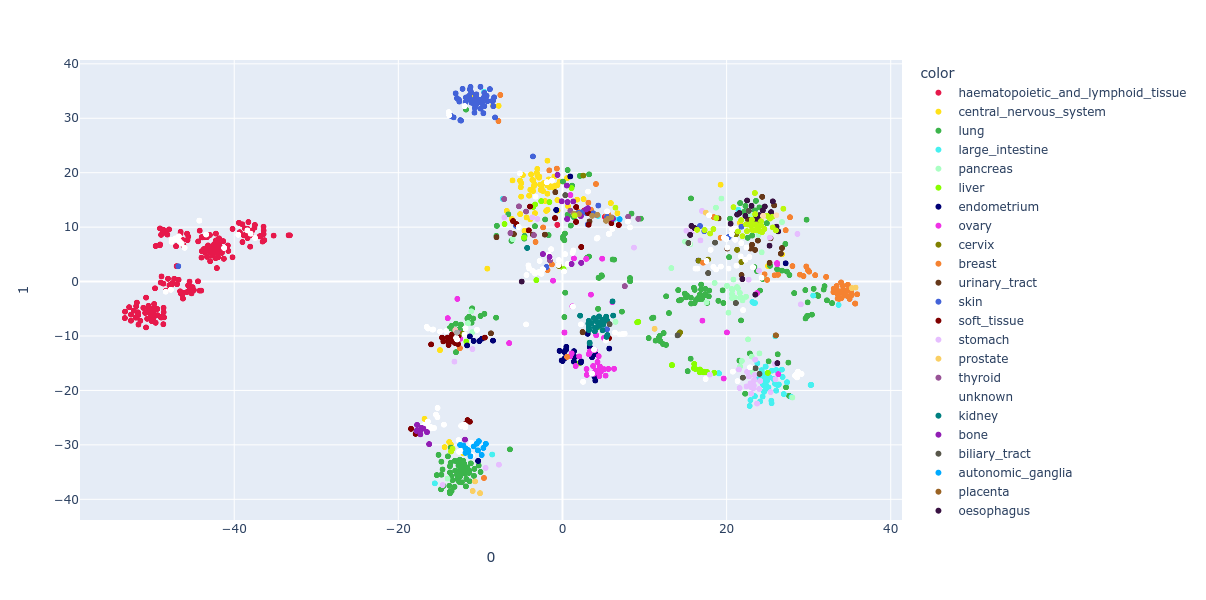

In [9]:
#--Getting some metadata
cl2tis = dict(zip(cll_metadata['cl_id'], cll_metadata['tissue']))
cl2name = dict(zip(cll_metadata['cl_id'], cll_metadata['cl_name']))
names = [cl2name[cl] if cl in cl2name else '' for cl in ids]
tissues = [cl2tis[cl] if cl in cl2tis else 'unknown' for cl in ids] # This will be used as side info to color the tSNE!

#Mapping the side info (e.g. tissues) to colors 
tis2col =  dict(zip(cll_metadata['tissue'], cll_metadata['color']))
tis2col['unknown'] = unknown_color

#--Data to be shown when hovering 
custom_data = {'ID':ids, 'Name':names, 'Tissue':tissues}


#Calling the interactive tSNE
plot_interactive_tSNE(emb2D, 
                      custom_data=custom_data, # Data to be shown when hovering
                      side_info_labels=tissues, side_info_labels_colors=tis2col #List of labels to color and color dictionary
                     )

## **2) Exploring embedding distances**

Embeddings allow us to explore similarities between entities. To do so we usually rely on distances between the vectors.

### **2.1) Obtaining pairwise distances between cell lines**

The scipy packages offer us handy functions to compute distances between embeddings. The *cdist()* function will calculate every pairwise distance between 2 matrix according to a given distance metric. We will use cosine distances as they have proven to be better suited for doing similarity queries in our resource.

In [10]:
from scipy.spatial.distance import cdist

# As the source and target entities in the metapath are homogeneous and undirected, we will compute pairwise distances between themselves
distance_metric = 'cosine'
source_ids, source_emb = ids, emb
target_ids, target_emb = ids, emb # This has to change if the metapath have a different target entity!

distances = cdist(source_emb, target_emb, metric=distance_metric)
distances = pd.DataFrame(distances,index = source_ids,  columns= target_ids)

distances

CVCL_0002     CVCL_0004  CVCL_0006  CVCL_0007     CVCL_0008  \
CVCL_0002   0.000000  4.692323e-01   0.326993   0.155899  3.023819e-01   
CVCL_0004   0.469232  1.110223e-16   0.551236   0.441482  5.371000e-01   
CVCL_0006   0.326993  5.512362e-01   0.000000   0.291946  5.082676e-01   
CVCL_0007   0.155899  4.414824e-01   0.291946   0.000000  3.263870e-01   
CVCL_0008   0.302382  5.371000e-01   0.508268   0.326387  2.220446e-16   
...              ...           ...        ...        ...           ...   
CVCL_X504   0.297854  5.354157e-01   0.495149   0.299632  1.218897e-01   
CVCL_X981   0.865706  8.647590e-01   0.878732   0.844216  7.685489e-01   
CVCL_Y545   0.428179  6.273036e-01   0.586614   0.449317  2.539917e-01   
CVCL_Y547   0.435461  6.631939e-01   0.566060   0.448112  2.632639e-01   
CVCL_Y548   0.284926  5.244598e-01   0.512233   0.319815  1.537007e-01   

           CVCL_0009  CVCL_0012  CVCL_0014  CVCL_0018  CVCL_0021  ...  \
CVCL_0002   0.517798   0.703272   0.415479   0.910548   0.961961  ...   
CVCL_0004   0.632721   0.833037   0.573871   0.918965   0.887427  ...   
CVCL_0006   0.678651   0.839126   0.553251   1.014898   0.916059  ...   
CVCL_0007   0.442558   0.752549   0.455167   0.971588   0.959683  ...   
CVCL_0008   0.304986   0.488220   0.212086   0.759791   0.849789  ...   
...              ...        ...        ...        ...        ...  ...   
CVCL_X504   0.345249   0.534226   0.245422   0.746557   0.886286  ...   
CVCL_X981   0.782257   1.000355   0.902588   0.639513   0.752379  ...   
CVCL_Y545   0.373334   0.572826   0.328970   0.842990   0.935461  ...   
CVCL_Y547   0.388264   0.607273   0.418017   0.883737   0.995937  ...   
CVCL_Y548   0.328731   0.576720   0.258721   0.800585   0.902462  ...   

           CVCL_WS70  CVCL_WS73  CVCL_WU66  CVCL_WU67  CVCL_WU91  \
CVCL_0002   0.905022   0.963535   0.985691   1.007317   0.898142   
CVCL_0004   0.801287   0.900996   0.864961   0.956066   0.886673   
CVCL_0006   0.918224   0.951180   0.986992   0.958321   0.943644   
CVCL_0007   0.887692   0.921406   0.951640   0.940061   0.928115   
CVCL_0008   0.877096   0.752802   0.871157   0.855414   0.900066   
...              ...        ...        ...        ...        ...   
CVCL_X504   0.821365   0.795581   0.895473   0.881459   0.861080   
CVCL_X981   0.431259   0.803504   0.700147   0.706773   0.266696   
CVCL_Y545   0.941058   0.845617   0.915410   0.902067   0.941757   
CVCL_Y547   0.956357   0.873469   0.930195   0.877164   0.983513   
CVCL_Y548   0.896091   0.849620   0.914454   0.906823   0.929806   

              CVCL_X504     CVCL_X981  CVCL_Y545  CVCL_Y547  CVCL_Y548  
CVCL_0002  2.978543e-01  8.657064e-01   0.428179   0.435461   0.284926  
CVCL_0004  5.354157e-01  8.647590e-01   0.627304   0.663194   0.524460  
CVCL_0006  4.951493e-01  8.787317e-01   0.586614   0.566060   0.512233  
CVCL_0007  2.996320e-01  8.442158e-01   0.449317   0.448112   0.319815  
CVCL_0008  1.218897e-01  7.685489e-01   0.253992   0.263264   0.153701  
...                 ...           ...        ...        ...        ...  
CVCL_X504  1.110223e-16  7.202938e-01   0.300183   0.351275   0.152756  
CVCL_X981  7.202938e-01  1.110223e-16   0.889302   0.897847   0.842003  
CVCL_Y545  3.001828e-01  8.893016e-01   0.000000   0.129213   0.282235  
CVCL_Y547  3.512752e-01  8.978473e-01   0.129213   0.000000   0.290823  
CVCL_Y548  1.527564e-01  8.420034e-01   0.282235   0.290823   0.000000  

[1198 rows x 1198 columns]

As in this case the matrix is symmetric (CLL-CLL), it is convenient to mask self-distances (the diagonal) to prevent them appear as neighbours

In [11]:
np.fill_diagonal(distances.values, np.nan)
distances

CVCL_0002  CVCL_0004  CVCL_0006  CVCL_0007  CVCL_0008  CVCL_0009  \
CVCL_0002        NaN   0.469232   0.326993   0.155899   0.302382   0.517798   
CVCL_0004   0.469232        NaN   0.551236   0.441482   0.537100   0.632721   
CVCL_0006   0.326993   0.551236        NaN   0.291946   0.508268   0.678651   
CVCL_0007   0.155899   0.441482   0.291946        NaN   0.326387   0.442558   
CVCL_0008   0.302382   0.537100   0.508268   0.326387        NaN   0.304986   
...              ...        ...        ...        ...        ...        ...   
CVCL_X504   0.297854   0.535416   0.495149   0.299632   0.121890   0.345249   
CVCL_X981   0.865706   0.864759   0.878732   0.844216   0.768549   0.782257   
CVCL_Y545   0.428179   0.627304   0.586614   0.449317   0.253992   0.373334   
CVCL_Y547   0.435461   0.663194   0.566060   0.448112   0.263264   0.388264   
CVCL_Y548   0.284926   0.524460   0.512233   0.319815   0.153701   0.328731   

           CVCL_0012  CVCL_0014  CVCL_0018  CVCL_0021  ...  CVCL_WS70  \
CVCL_0002   0.703272   0.415479   0.910548   0.961961  ...   0.905022   
CVCL_0004   0.833037   0.573871   0.918965   0.887427  ...   0.801287   
CVCL_0006   0.839126   0.553251   1.014898   0.916059  ...   0.918224   
CVCL_0007   0.752549   0.455167   0.971588   0.959683  ...   0.887692   
CVCL_0008   0.488220   0.212086   0.759791   0.849789  ...   0.877096   
...              ...        ...        ...        ...  ...        ...   
CVCL_X504   0.534226   0.245422   0.746557   0.886286  ...   0.821365   
CVCL_X981   1.000355   0.902588   0.639513   0.752379  ...   0.431259   
CVCL_Y545   0.572826   0.328970   0.842990   0.935461  ...   0.941058   
CVCL_Y547   0.607273   0.418017   0.883737   0.995937  ...   0.956357   
CVCL_Y548   0.576720   0.258721   0.800585   0.902462  ...   0.896091   

           CVCL_WS73  CVCL_WU66  CVCL_WU67  CVCL_WU91  CVCL_X504  CVCL_X981  \
CVCL_0002   0.963535   0.985691   1.007317   0.898142   0.297854   0.865706   
CVCL_0004   0.900996   0.864961   0.956066   0.886673   0.535416   0.864759   
CVCL_0006   0.951180   0.986992   0.958321   0.943644   0.495149   0.878732   
CVCL_0007   0.921406   0.951640   0.940061   0.928115   0.299632   0.844216   
CVCL_0008   0.752802   0.871157   0.855414   0.900066   0.121890   0.768549   
...              ...        ...        ...        ...        ...        ...   
CVCL_X504   0.795581   0.895473   0.881459   0.861080        NaN   0.720294   
CVCL_X981   0.803504   0.700147   0.706773   0.266696   0.720294        NaN   
CVCL_Y545   0.845617   0.915410   0.902067   0.941757   0.300183   0.889302   
CVCL_Y547   0.873469   0.930195   0.877164   0.983513   0.351275   0.897847   
CVCL_Y548   0.849620   0.914454   0.906823   0.929806   0.152756   0.842003   

           CVCL_Y545  CVCL_Y547  CVCL_Y548  
CVCL_0002   0.428179   0.435461   0.284926  
CVCL_0004   0.627304   0.663194   0.524460  
CVCL_0006   0.586614   0.566060   0.512233  
CVCL_0007   0.449317   0.448112   0.319815  
CVCL_0008   0.253992   0.263264   0.153701  
...              ...        ...        ...  
CVCL_X504   0.300183   0.351275   0.152756  
CVCL_X981   0.889302   0.897847   0.842003  
CVCL_Y545        NaN   0.129213   0.282235  
CVCL_Y547   0.129213        NaN   0.290823  
CVCL_Y548   0.282235   0.290823        NaN  

[1198 rows x 1198 columns]

### **2.2) Plotting distance distributions**

To have an idea of the distance ranges we can take a subset of the matrix to plot a distribution

Text(0.5, 0, 'Distance')

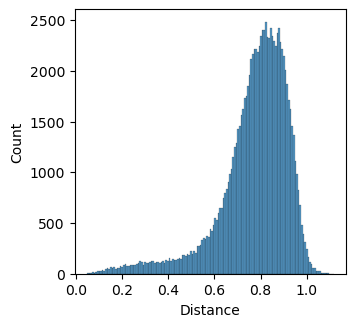

In [12]:
plt.figure(figsize=(3.5,3.5),dpi=100)
sns.histplot(np.random.choice(distances.values.ravel(),100000))
plt.xlabel('Distance')

Notice how most of the cell-cell pairs have a distance between ~0.7 and 0.9. Interestingly, the increased count at the left tail of the distribution suggest that there are an important amount of cell line pairs that that are pretty similar in this space.

### **2.3) Standardizing the distances**

We can also standardize the distances in order to have a more stastistical description of our distribution. While we could apply a standard scaler to do so (substract the mean and divide by the standard deviation), we can also use other scalers that are more robust when dealing with non-normal distributions, as in our case. Here I will use the *robust scale* from sklearn which make use of the median and the Inter Quartile Range (IQR) of the distribution.

Text(0.5, 0, 'Norm Distance')

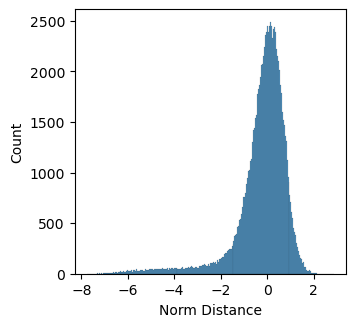

In [13]:
from sklearn.preprocessing import robust_scale
distances_scaled = pd.DataFrame(robust_scale(distances), columns = distances.columns, index= distances.index.values)

plt.figure(figsize=(3.5,3.5),dpi=100)
sns.histplot(np.random.choice(distances_scaled.values.ravel(),100000))
plt.xlabel('Norm Distance')

Importantly, as this scaling is applied individually to each cell line, distances now will be more comparable between them. 
Notice how now the median of the distribution is centered at 0, while the more negative the value the more smaller is a given distance. 

### **2.4) Obtaining Nearest neighbours**

Sometimes we may be interested in finding a node that resembles another of interest. 

For instance, we may want to find similar cell lines to the one we have been working with in order to replicate our findings in other samples, or just because our vendor is not providing our cell line of interest at that moment.


To this goal, we can compute the closest neighbours to our cell line of interest according to their distance in an embedding space. 

**Note**: Notice that the Bioteque provides different embedding spaces capturing different similarities between cell lines. Therefore, it is important to first decide which biological context would make more sense to look for similarities. Having said that, we know that gene-expression-based embeddings are pretty decent at preserving relevant biological information of the cell lines (e.g. their tissue of origin).

Sometimes we may be interested in finding a node that resembles another of interest. 

For instance, we may want to find similar cell lines to the one we have been working with in order to replicate our findings in other samples or may be because the vendor has not this cell line available. While we can compare cell lines according to different embeddings, we now that gene expression is good at recapitulating important cell line properties as their tissue lineage.

In [14]:
#Given a distance dataframe and a desired number of neighbours, this function calculates the closest neighbours for each cell line in the dataframe
def get_cl2neighbours(distances_df, K_neighs=5):
    
    cl2neigh = {}
    for cl, dist_v in distances_df.iterrows():

        neighb_ixs = np.argsort(dist_v.values)[:K_neighs]

        cl2neigh[cl] = list(zip(dist_v.index.values[neighb_ixs],
                                dist_v.values[neighb_ixs]
                               ))
    return cl2neigh

#------

# 1) Obtain neighbours
K_neighs = 5
distance_df = distances
cl2neigh = get_cl2neighbours(distance_df, K_neighs)

# 2) Read some metadata to map cell ids to their name or tissue
cl2tis = dict(cll_metadata[['cl_id','tissue']].values)
cl2name = dict(cll_metadata[['cl_id','cl_name']].values)

# 3) Print the neighbours for a cell line of interest
cell_of_interest = 'CVCL_0002'

for ix, (neighbour,dist) in enumerate(cl2neigh[cell_of_interest]):
    print("""
    neighbour rank: %i
    cell_name: %s
    cell_id: %s
    tissue: %s
    dist: %s
    """%(ix+1,
         cl2name[neighbour] if neighbour in cl2name else '???',
         neighbour, 
         cl2tis[neighbour] if neighbour in cl2tis else '???',
         dist)
         )
 


    neighbour rank: 1
    cell_name: PLB985
    cell_id: CVCL_2162
    tissue: haematopoietic_and_lymphoid_tissue
    dist: 0.13701401468907193
    

    neighbour rank: 2
    cell_name: SKNO1
    cell_id: CVCL_2196
    tissue: haematopoietic_and_lymphoid_tissue
    dist: 0.14033671824645622
    

    neighbour rank: 3
    cell_name: KASUMI6
    cell_id: CVCL_0614
    tissue: haematopoietic_and_lymphoid_tissue
    dist: 0.1478785665217689
    

    neighbour rank: 4
    cell_name: MOLM13
    cell_id: CVCL_2119
    tissue: haematopoietic_and_lymphoid_tissue
    dist: 0.15358355707724802
    

    neighbour rank: 5
    cell_name: EOL1
    cell_id: CVCL_0258
    tissue: haematopoietic_and_lymphoid_tissue
    dist: 0.15486179386356613
    


We have identified 5 closest neighbours that are really close to our cell line of interest! You can check the distance distribution to have some reference of how much close these cell lines are. 

Hoewver, while the 5 neighbours share the same tissue of origin (haematopoietic/lympoid lineage), it seems there are apparent differences in their distances to our reference cell. Sometimes we can have a better resolution of these differences when we use standardized distances. Let's repeat the same exercise using the scaled distance matrix:

In [15]:

# 1) Obtain neighbours
K_neighs = 5
distance_df = distances_scaled
cl2neigh = get_cl2neighbours(distance_df, K_neighs)

# 2) Read some metadata to map cell ids to their name or tissue
cl2tis = dict(cll_metadata[['cl_id','tissue']].values)
cl2name = dict(cll_metadata[['cl_id','cl_name']].values)

# 3) Print the neighbours for a cell line of interest
cell_of_interest = 'CVCL_0002'

for ix, (neighbour,dist) in enumerate(cl2neigh[cell_of_interest]):
    print("""
    neighbour rank: %i
    cell_name: %s
    cell_id: %s
    tissue: %s
    dist: %s
    """%(ix+1,
         cl2name[neighbour] if neighbour in cl2name else '???',
         neighbour, 
         cl2tis[neighbour] if neighbour in cl2tis else '???',
         dist)
         )
 


    neighbour rank: 1
    cell_name: MONOMAC1
    cell_id: CVCL_1425
    tissue: haematopoietic_and_lymphoid_tissue
    dist: -7.9609011176796916
    

    neighbour rank: 2
    cell_name: MOLM13
    cell_id: CVCL_2119
    tissue: haematopoietic_and_lymphoid_tissue
    dist: -7.519174044393892
    

    neighbour rank: 3
    cell_name: PLB985
    cell_id: CVCL_2162
    tissue: haematopoietic_and_lymphoid_tissue
    dist: -6.99246121548952
    

    neighbour rank: 4
    cell_name: EOL1
    cell_id: CVCL_0258
    tissue: haematopoietic_and_lymphoid_tissue
    dist: -6.875911756461969
    

    neighbour rank: 5
    cell_name: MONOMAC6
    cell_id: CVCL_1426
    tissue: haematopoietic_and_lymphoid_tissue
    dist: -6.758345989591369
    


Now we can see that all of them are very close to our cell line of interest, but there is 1 unit of difference between the TOP 1 (-7.9) and TOP 3 (-6.9) neighbours!

**Important**: To avoid recomputing distances each time for a neighbour search, you can consider using the FAISS implementation developed by Facebook Research (https://github.com/facebookresearch/faiss). The use of FAISS not only will allow a faster query of close neighbours but also can handle, very efficiently, much bigger embedding spaces.

## **3) Clustering**

Some times we may want to cluster the embeddings to obtain representative groups (cluster of cell lines) or to better understand the structure of the space.

### **3.1) Visualizing the embedding vectors**

One way to do so is to cluster the embedding space and visualize the cluster with a heatmap. We can use the *clustermap* function from the seaborn package to do so. In order to have an idea of the information encoded in each dimension, we will only cluster the samples (cell lines) and keep the vector dimensions untouched. Moreover, we will color the cell lines by tissue of origin, to have a better understanding of how they cluster. 

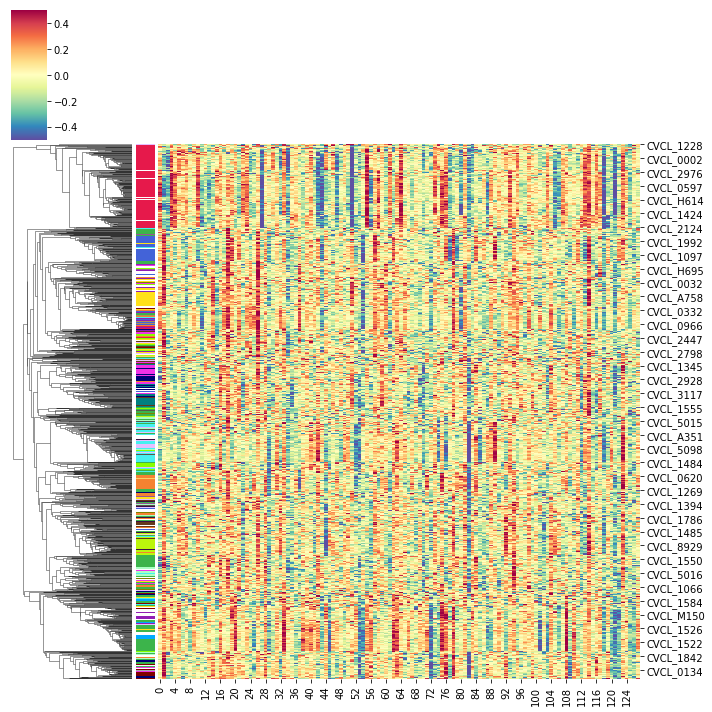

In [16]:
#-- Assembling our embedding matrix and ids into a dataframe
df_to_cluster = pd.DataFrame(emb, index=ids)

#-- Clustering and visualizing the embedding. Notice how we only cluster the samples to preserve the order of the vector dimensions.
sns.clustermap(df_to_cluster, metric='cosine', row_colors=colors, cmap='Spectral_r', col_cluster=False, vmin=-0.5,vmax=0.5)


In this cluster, rows represent cell lines (colored by tissue of origin) and the columns represent each of the 128d dimensions, without clustering them. Notice how we can see some clear tissue clusters, in good agreement with the 2D representation we did before. More importantly, it seems there are some embedding dimensions that have particular weights for some of these cell line clusters.

We can now repeat this clustering but allowing the embedding dimensions (columns) cluster as well.

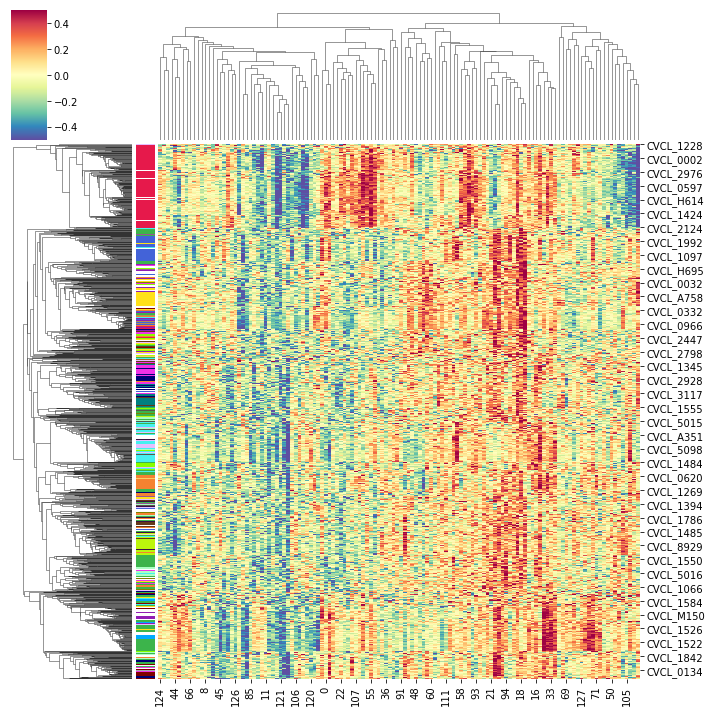

In [17]:
sns.clustermap(df_to_cluster, metric='cosine', row_colors=colors, cmap='Spectral_r', col_cluster=True, vmin=-0.5, vmax=0.5)


By allowing the cluster of the dimensions we can have a better idea of which specific dimensions appear to be related to specific cell line groups.

### **3.2) Clustering embedding distances**

While the clusteiring based on embedding dimensions may help us to better understand the structure of the space, the dimensions themselfs have not any explicit meaning. Usually, more interesting assocations can be uncovered when we cluster nodes according to the distance of their embeddings, instead of their raw dimensional values. 

Here we repeat the same clustering but first computing the distance matrix between the samples. To this goal, we can use the *cdist* function from the scipy package as we did before.

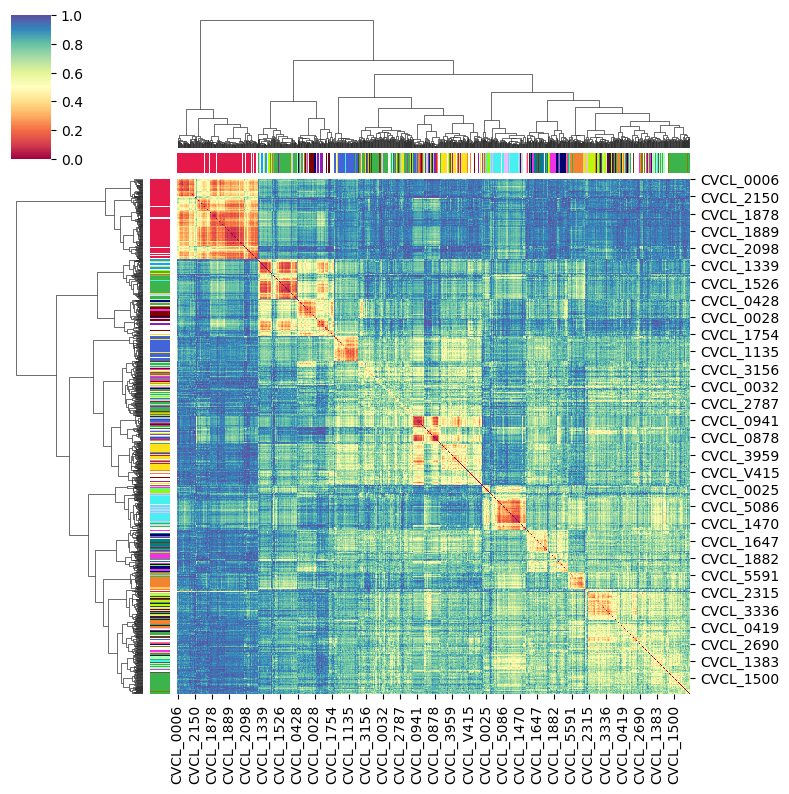

In [18]:
from scipy.cluster import hierarchy 

linkage = hierarchy.linkage(emb, method='ward')
df_distances = pd.DataFrame(cdist(emb,emb, 'cosine'), index=ids, columns=ids)
sns.clustermap(df_distances, row_linkage=linkage, col_linkage=linkage,
               row_colors=colors, col_colors=colors,cmap='Spectral', vmax=1, vmin=0, figsize=(8,8))

In good agreement with the 2D projection, we see that distances between the 128d embeddings also recapitulate some tissue lineages. From this clustering, is evident how hematopietic cell lines (red) are not only very similar among them but also are very far apart from the rest of tissue lineages.

**Disclaimer:** The *clustermap* function may struggle when dealing with tens of thousands of samples. You may consider other alternatives for clustering (such as fastcluster (https://pypi.org/project/fastcluster/) or dbscan (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)) and/or subsample a set of samples for their visualization.

## **4) Prediction**

The low-dimensionality and continous space of our embeddings makes them very suitable for machine learning pipelines. For instance, we could train a predictor model to infer the drug sensivity for a particular drug using those cell lines with annotations, and then use our model to predict the sensitivity of other cell lines in the embedding space that have not been tested.

To simplify the exercise we will model this problem as a classification prediction, using the binarized sensitive calls provided in the GDSC1000: https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Drug_screening_data.html. We have already preprocesed these data for you and mapped the GDSC cell line ids to their corresponding Cellosaurus ids.

### **4.1) Reading sensitvity data**

First, let's read the sensitivity data available in the GDSC1000 resource

In [19]:
# Read cell sensitivity data
cll_sens = pd.read_csv(metadata_path+'/gdsc1000_sens_callings.csv.gz')

# Remove cell line rows that were not mapped to cellosaurus IDs
cll_sens = cll_sens[~pd.isnull(cll_sens['Cells_id'])]

cll_sens

Cells   Cells_id Erlotinib Rapamycin Sunitinib PHA-665752 MG-132  \
0        A253  CVCL_1060         S         R         R          R      R   
1    BB30-HNC  CVCL_1076         S         R         R          R      R   
2    BB49-HNC  CVCL_1077         R         R         R          R      R   
3         BHY  CVCL_1086       NaN       NaN       NaN        NaN    NaN   
4      BICR10  CVCL_2307       NaN       NaN       NaN        NaN    NaN   
..        ...        ...       ...       ...       ...        ...    ...   
979    JIMT-1  CVCL_2077       NaN       NaN       NaN        NaN    NaN   
980     CL-34  CVCL_1980       NaN       NaN       NaN        NaN    NaN   
981  VMRC-LCD  CVCL_1787       NaN       NaN       NaN        NaN    NaN   
983  STS-0421  CVCL_X508       NaN       NaN       NaN        NaN    NaN   
997      KP-2  CVCL_3004       NaN       NaN       NaN        NaN    NaN   

    Paclitaxel Cyclopamine AZ628  ... Temozolomide Afatinib (rescreen)  \
0            R           R     R  ...            S                   R   
1            S           S     R  ...            R                   S   
2            R           R     S  ...            R                   R   
3          NaN         NaN   NaN  ...            R                   S   
4          NaN         NaN   NaN  ...            R                   R   
..         ...         ...   ...  ...          ...                 ...   
979        NaN         NaN   NaN  ...            R                   R   
980        NaN         NaN   NaN  ...            R                   R   
981        NaN         NaN   NaN  ...            R                   R   
983        NaN         NaN   NaN  ...            R                   R   
997        NaN         NaN   NaN  ...            R                   R   

    Bleomycin (50 uM) SN-38 Olaparib.1 AZD6244.1 Bicalutamide.1  \
0                   S     R          R         R              R   
1                   S     R          S         S              R   
2                   R     R          R         S              R   
3                   R     R          R         R              R   
4                   R     R          R         R              R   
..                ...   ...        ...       ...            ...   
979                 R     R          R         R              R   
980                 R     R          R         S              R   
981                 R     R          R         R              R   
983                 R     R          R         R              R   
997                 R     R          R         S              S   

    RDEA119 (rescreen) GDC0941 (rescreen) MLN4924   
0                    R                  R       R   
1                  NaN                NaN           
2                    S                  S       R   
3                    R                  R       R   
4                    R                  R           
..                 ...                ...      ...  
979                  R                  R           
980                  S                  R       R   
981                  R                  R       R   
983                  R                  R           
997                  S                  R       R   

[930 rows x 267 columns]

We can see  how our matrix contains 930 cell lines and 265 drugs. However, notice how not every drug have been tested to every cell lines so we won't have the same amount of data for every drug.

Also, notice that our embedding space is based on the Cancer Cell Line Encyclopedia (CCLE) while the sensitivity was measured in GDSC1000. Therefore, we first need to find the common subset of cell lines between our embedding space (CCLE) and the sensitivity data (GDSC).

In [20]:
# restricting the sensitivity to our set of cell lines
cll_sens = cll_sens[cll_sens['Cells_id'].isin(set(ids))]
cll_sens

Cells   Cells_id Erlotinib Rapamycin Sunitinib PHA-665752 MG-132  \
0       A253  CVCL_1060         S         R         R          R      R   
3        BHY  CVCL_1086       NaN       NaN       NaN        NaN    NaN   
5     BICR22  CVCL_2310       NaN       NaN       NaN        NaN    NaN   
6     BICR31  CVCL_2312       NaN       NaN       NaN        NaN    NaN   
7     BICR78  CVCL_2315       NaN       NaN       NaN        NaN    NaN   
..       ...        ...       ...       ...       ...        ...    ...   
975  OCI-LY7  CVCL_1881       NaN       NaN       NaN        NaN    NaN   
976   KMS-11  CVCL_2989       NaN       NaN       NaN        NaN    NaN   
979   JIMT-1  CVCL_2077       NaN       NaN       NaN        NaN    NaN   
980    CL-34  CVCL_1980       NaN       NaN       NaN        NaN    NaN   
997     KP-2  CVCL_3004       NaN       NaN       NaN        NaN    NaN   

    Paclitaxel Cyclopamine AZ628  ... Temozolomide Afatinib (rescreen)  \
0            R           R     R  ...            S                   R   
3          NaN         NaN   NaN  ...            R                   S   
5          NaN         NaN   NaN  ...            R                   S   
6          NaN         NaN   NaN  ...          NaN                 NaN   
7          NaN         NaN   NaN  ...            R                   S   
..         ...         ...   ...  ...          ...                 ...   
975        NaN         NaN   NaN  ...          NaN                 NaN   
976        NaN         NaN   NaN  ...            R                   R   
979        NaN         NaN   NaN  ...            R                   R   
980        NaN         NaN   NaN  ...            R                   R   
997        NaN         NaN   NaN  ...            R                   R   

    Bleomycin (50 uM) SN-38 Olaparib.1 AZD6244.1 Bicalutamide.1  \
0                   S     R          R         R              R   
3                   R     R          R         R              R   
5                   S     R          R         S              R   
6                 NaN   NaN        NaN       NaN            NaN   
7                   R     R          R         S              R   
..                ...   ...        ...       ...            ...   
975                 R     R        NaN       NaN            NaN   
976                 R     R          R         R              R   
979                 R     R          R         R              R   
980                 R     R          R         S              R   
997                 R     R          R         S              S   

    RDEA119 (rescreen) GDC0941 (rescreen) MLN4924   
0                    R                  R       R   
3                    R                  R       R   
5                    S                  R       R   
6                  NaN                NaN           
7                    R                  R       R   
..                 ...                ...      ...  
975                NaN                NaN           
976                  R                  S       R   
979                  R                  R           
980                  S                  R       R   
997                  S                  R       R   

[639 rows x 267 columns]

We now have 639 cell lines in common. The next step is to choose our drug of interest. Here we will use "Dabrafenib" since it has been measured in multiple cell lines and it seems we have enough sensitivite (S) for the training.

In [21]:
#--Drug of interest
drug = 'Dabrafenib'

#--Getting cell vector and sensitivity 
_cl_v = np.array(cll_sens['Cells_id'])
_dg_v = np.array(cll_sens[drug])

#--Counting hits
print(Counter(_dg_v))



Counter({'R': 474, 'S': 91, nan: 74})


We can see that we have 474 Resistant (R), 91 Sensitivte (S) and 74 unmeasured cell lines (nan). 

The next step is to remove the unmeasured cell lines as we don't have labels for training them.

In [22]:
# -- Obtaining a masking of cell lines that are not nan
screen_ixs = ~pd.isnull(_dg_v)

#-- Implementing the masking
cl_v = _cl_v[screen_ixs]
dg_v = _dg_v[screen_ixs]

#--Counting hits
print(Counter(dg_v))

Counter({'R': 474, 'S': 91})


Now we need to prepare the data for our prediction. These are the matrix ***X*** of embeddings (used as features for the cell lines) and the vector ***Y*** with the binary sensitivity labels that our model has to classify.

In [23]:
#-- Getting X matrix (features)
cl2emb = dict(zip(ids, emb)) # This maps each cell label to their corresponding embedding
X = np.array([cl2emb[cl] for cl in cl_v]) # Getting the embedding of each cell line from our cell vector
             
#-- Getting Y vector (labels)
from sklearn.preprocessing import label_binarize
Y = label_binarize(dg_v, classes=['R','S']).ravel() # Transforming 'R' and 'S' labels into binary vector (0,1)

#-- Randomizing the vectors to avoid biases during the training.
rixs = np.random.permutation(np.arange(len(Y)))
cl_v, dg_v, X, Y = cl_v[rixs], dg_v[rixs], X[rixs], Y[rixs] 
X.shape, Y.shape

((565, 128), (565,))

Now we have our Matrix X with 565 cell lines and 128 features (our embedding dimension) and the Vector Y defining the binary sensitivity of our drug.

Next step is to prepare a K-Fold iterator to train our data using different fold splits. As our data is unbalanced (we have more resistant cell lines than sensitivite) we will use a 10-Fold Stratified split which will preserve the proportion of positive/negative instances in each split.

In [24]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10)

Time to train! As a model will use the *Random Forest Classifier* from sklearn. We will use the default hyperparameters with exception of the number of trees (we set to 1000) and the class weight (which we set to 'balanced' in order to account for our data imbalance).

The training of the 10 models (one for each split) should take few minutes to complete.

In [25]:
from sklearn.ensemble import RandomForestClassifier

n_cpus = -1 # Adjust this in case you want to prevent the model from using all your CPUs
train_results, test_results = [],[]

#--Iterating across the K-fold splits
for train_ixs, test_ixs in skf.split(X,Y):
    
    #--Train data
    xtr = X[train_ixs]
    ytr = Y[train_ixs]
    
    #--Test data
    xts = X[test_ixs]
    yts = Y[test_ixs]
    
    #-- Initializing the random forest of the split
    rfc = RandomForestClassifier(n_estimators=1000, class_weight='balanced', n_jobs=n_cpus)
    
    #-- Training the model
    rfc.fit(xtr, ytr)
    
    #--Obtaining predicted probabilities for the train and test datasets
    train_pred = rfc.predict_proba(xtr)[:,1]
    test_pred = rfc.predict_proba(xts)[:,1]
    
    #--Saving the results of the split
    train_results.extend(zip(cl_v[train_ixs],train_pred, ytr))
    test_results.extend(zip(cl_v[test_ixs],test_pred, yts))

#-- Transforming the results into a dataframe
train_results = pd.DataFrame(train_results, columns=['cl','pred','true'])
test_results = pd.DataFrame(test_results, columns=['cl','pred','true'])

train_results['split'] = 'train'
test_results['split'] = 'test'

print('Done!')

Done!


Now is time to analyse the results. For that we can either inspect the distribution of probabilities or compute some classical performance metrics such the ROC or AUPR curves.

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

<AxesSubplot:xlabel='split', ylabel='pred'>

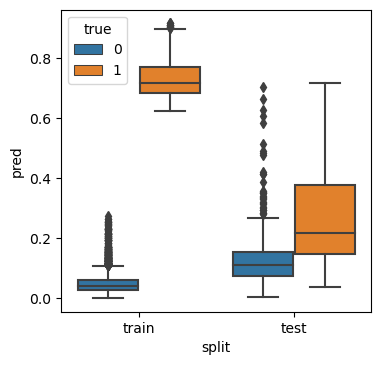

In [27]:
#Plotting distribution of probabilities
plt.figure(figsize=(4,4), dpi=100)
sns.boxplot(y='pred', x='split', hue='true',data=pd.concat([train_results, test_results]))

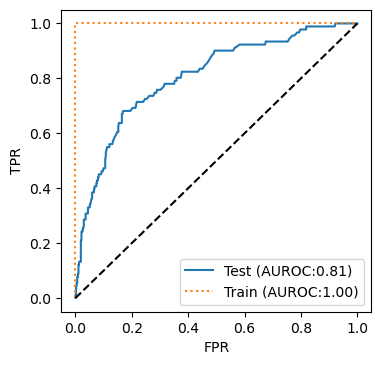

In [28]:
# Plotting the ROC curve
plt.figure(figsize=(4,4),dpi=100)

#--Test
fpr,tpr,thr = roc_curve(test_results['true'], test_results['pred'])
plt.plot(fpr,tpr, label='Test (AUROC:%.2f)'%auc(fpr,tpr))

#--Train
fpr,tpr,thr = roc_curve(train_results['true'], train_results['pred'])
plt.plot(fpr,tpr, label='Train (AUROC:%.2f)'%auc(fpr,tpr), ls=':')


plt.plot([0,1],[0,1], ls='--', color='k')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

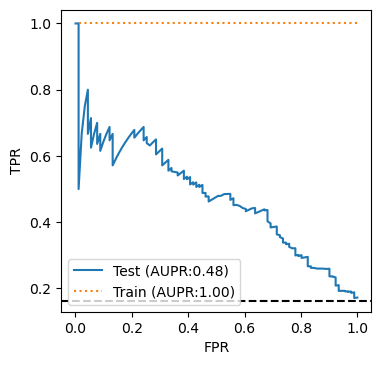

In [29]:
# Plotting the AUPR curve
plt.figure(figsize=(4,4),dpi=100)

#--Test
prc,rec,thr = precision_recall_curve(test_results['true'], test_results['pred'])
plt.plot(rec,prc, label='Test (AUPR:%.2f)'%auc(rec,prc))

#--Train
prc,rec,thr = precision_recall_curve(train_results['true'], train_results['pred'])
plt.plot(rec,prc, label='Train (AUPR:%.2f)'%auc(rec,prc), ls=':')


plt.axhline(Y.sum()/len(Y), color='k', ls='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

It seems our model is not doing bad! However notice that the performance obtained in the test set is still far from the training set, suggesting that we may be doing overffiting. Remember that Random Forest classifiers have some hyperparameters that are worth to fine-tuning in order to improve the results ;)